In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
import pandas_datareader.data as web

In [2]:
# ============================
# Step 1: Load and clean Compustat quarterly data
# ============================
def load_compustat_quarterly(filepath):
    cols = ['gvkey','datadate','fyearq','fqtr','niq','cshoq']
    comp = pd.read_csv(filepath, usecols=cols, parse_dates=['datadate'])
    comp = comp.sort_values(['gvkey','fyearq','fqtr'])
    comp['cshoq_filled'] = comp.groupby(['gvkey','fyearq'])['cshoq'].transform('ffill')
    return comp

In [3]:
comp = load_compustat_quarterly('COMPUSTAT.csv')

In [4]:
comp

,gvkey,datadate,fyearq,fqtr,cshoq,niq,cshoq_filled
0,1000,1966-03-31,1966,1,0.219,NaN,0.219
1,1000,1966-06-30,1966,2,0.219,NaN,0.219
2,1000,1966-09-30,1966,3,0.219,NaN,0.219
3,1000,1966-12-31,1966,4,0.219,0.164,0.219
4,1000,1967-03-31,1967,1,0.277,NaN,0.277
...,...,...,...,...,...,...,...
1837164,356128,2023-12-31,2023,4,189.333,605.021,189.333
1837165,356128,2024-03-31,2024,1,190.009,492.466,190.009
1837166,356128,2024-06-30,2024,2,190.016,475.431,190.016
1837167,356128,2024-09-30,2024,3,190.016,546.722,190.016


In [5]:
# ============================
# Step 2: Extract year-end records and compute annual EPS
# ============================
def compute_annual_eps(comp):
    year_end = comp[comp['fqtr'] == 4].copy()
    annual_ni = comp.groupby(['gvkey','fyearq'])['niq'].sum().reset_index().rename(columns={'niq':'annual_ni'})
    year_end = year_end.merge(annual_ni, on=['gvkey','fyearq'], how='left')
    year_end['shares_year_end'] = year_end['cshoq_filled']
    return year_end

In [6]:
year_end = compute_annual_eps(comp)

In [7]:
year_end

,gvkey,datadate,fyearq,fqtr,cshoq,niq,cshoq_filled,annual_ni,shares_year_end
0,1000,1966-12-31,1966,4,0.219,0.164,0.219,0.164,0.219
1,1000,1967-12-31,1967,4,0.277,0.039,0.277,0.039,0.277
2,1000,1968-12-31,1968,4,0.664,1.538,0.664,1.538,0.664
3,1000,1969-12-31,1969,4,2.230,0.511,2.230,1.765,2.230
4,1000,1970-12-31,1970,4,2.446,-1.064,2.446,0.558,2.446
...,...,...,...,...,...,...,...,...,...
446472,355398,2022-12-31,2022,4,61.933,-41.248,61.933,-41.248,61.933
446473,355398,2023-12-31,2023,4,61.933,23.501,61.933,25.653,61.933
446474,356128,2022-12-31,2022,4,190.310,429.647,190.310,1264.809,190.310
446475,356128,2023-12-31,2023,4,189.333,605.021,189.333,1855.692,189.333


In [8]:
# ============================
# Step 3: Fill missing shares using CRSP December SHROUT
# ============================
def fill_missing_shares(year_end, link_table, crsp):
    link_table = link_table[link_table['LINKPRIM'] == 'P'].copy()
    link_table['LINKDT'] = pd.to_datetime(link_table['LINKDT'], errors='coerce')
    link_table['LINKENDDT'] = pd.to_datetime(link_table['LINKENDDT'], errors='coerce')
    crsp['date'] = pd.to_datetime(crsp['date'], errors='coerce')

    mask_no_shares = year_end['shares_year_end'].isna()
    if mask_no_shares.any():
        temp = year_end[mask_no_shares].merge(link_table, on='gvkey', how='left')
        temp = temp[(temp['datadate'] >= temp['LINKDT']) & ((temp['datadate'] <= temp['LINKENDDT']) | temp['LINKENDDT'].isna())]
        temp['year'] = temp['datadate'].dt.year
        temp['month'] = temp['datadate'].dt.month

        crsp['year'] = crsp['date'].dt.year
        crsp['month'] = crsp['date'].dt.month

        temp = temp.merge(crsp[['PERMNO','year','month','SHROUT']],
                          left_on=['LPERMNO','year','month'], right_on=['PERMNO','year','month'], how='left')
        temp['shares_crsp'] = temp['SHROUT'] / 1000.0
        fill_shares = temp[['gvkey','fyearq','shares_crsp']].dropna()
        year_end = year_end.merge(fill_shares, on=['gvkey','fyearq'], how='left')
        year_end['shares_year_end'] = year_end['shares_year_end'].fillna(year_end['shares_crsp'])

    year_end.dropna(subset=['annual_ni','shares_year_end'], inplace=True)
    year_end['EPS'] = year_end['annual_ni'] / year_end['shares_year_end']
    return year_end[['gvkey','fyearq','EPS']]

In [9]:
link = pd.read_csv('Link Table.csv')
crsp = pd.read_csv('CRSP.csv')
eps_df = fill_missing_shares(year_end, link, crsp)

In [10]:
eps_df

,gvkey,fyearq,EPS
0,1000,1966,0.748858
1,1000,1967,0.140794
2,1000,1968,2.316265
3,1000,1969,0.791480
4,1000,1970,0.228128
...,...,...,...
446472,355398,2022,-0.666010
446473,355398,2023,0.414206
446474,356128,2022,6.646046
446475,356128,2023,9.801207


In [11]:
# ============================
# Step 4: Compute 5-year EPS dispersion per firm
# ============================
def compute_5y_eps_dispersion(eps_df):
    eps_df = eps_df.drop_duplicates(subset=['gvkey', 'fyearq'])
    eps_df = eps_df.sort_values(['gvkey','fyearq'])
    grouped = eps_df.groupby('gvkey')
    records = []
    for gvkey, group in grouped:
        if len(group) < 5:
            continue
        for i in range(5, len(group)):
            window = group.iloc[i-5:i]
            mean_eps = window['EPS'].mean()
            std_eps = window['EPS'].std(ddof=0)
            if abs(mean_eps) > 1e-8:
                disp = std_eps / abs(mean_eps)
                year = group.iloc[i]['fyearq']
                records.append({'gvkey': gvkey, 'year': year, 'dispersion': disp})
    return pd.DataFrame(records)

In [12]:
dispersion_df = compute_5y_eps_dispersion(eps_df)

In [13]:
dispersion_df

,gvkey,year,dispersion
0,1000,1971.0,0.924655
1,1000,1972.0,1.886899
2,1000,1973.0,1.504292
3,1000,1974.0,1.767442
4,1000,1975.0,1.655668
...,...,...,...
244885,345920,2024.0,1.221271
244886,345980,2023.0,0.479566
244887,345980,2024.0,1.461922
244888,347085,2023.0,1.226708


In [14]:
# ============================
# Step 5: Merge CRSP with dispersion data and compute returns
# ============================
def construct_dispersion_portfolios(crsp, link, dispersion_df):
    crsp = crsp.copy()
    crsp['date'] = pd.to_datetime(crsp['date'])
    link = link.copy()
    link['LINKDT'] = pd.to_datetime(link['LINKDT'], errors='coerce')
    link['LINKENDDT'] = pd.to_datetime(link['LINKENDDT'], errors='coerce')

    # Merge and filter valid links
    crsp_linked = crsp.merge(link, left_on='PERMNO', right_on='LPERMNO', how='left')
    crsp_linked = crsp_linked[
        (crsp_linked['date'] >= crsp_linked['LINKDT']) &
        ((crsp_linked['date'] <= crsp_linked['LINKENDDT']) | crsp_linked['LINKENDDT'].isna())
    ]

    # Add year and merge in dispersion
    crsp_linked['year'] = crsp_linked['date'].dt.year
    crsp_linked = crsp_linked.merge(dispersion_df, on=['gvkey','year'], how='left')
    crsp_linked = crsp_linked.dropna(subset=['dispersion'])

    # Price filter
    crsp_linked['price'] = crsp_linked['PRC'].abs()
    crsp_linked = crsp_linked[crsp_linked['price'] >= 5].copy()

    # Dispersion sorting into quintiles
    crsp_linked = crsp_linked.sort_values(['date','dispersion'])
    crsp_linked['disp_rank_pct'] = crsp_linked.groupby('date')['dispersion'].rank(pct=True)
    crsp_linked['quintile'] = (crsp_linked['disp_rank_pct'] * 5 + 1).astype(int).clip(1,5)

    # Clean returns
    crsp_linked['RET'] = pd.to_numeric(crsp_linked['RET'], errors='coerce')

    # Portfolio returns
    port_returns = crsp_linked.groupby(['date','quintile'])['RET'].mean().unstack()
    port_returns.columns = [f"D{int(c)}" for c in port_returns.columns]

    # Long-short signal
    if 'D1' in port_returns.columns and 'D5' in port_returns.columns:
        port_returns['D5_minus_D1'] = port_returns['D5'] - port_returns['D1']

    return port_returns, crsp_linked


In [15]:
port_returns, crsp_linked = construct_dispersion_portfolios(crsp, link, dispersion_df)

In [16]:
port_returns

,D1,D2,D3,D4,D5,D5_minus_D1
date,,,,,,
1966-01-31,-0.004092,0.042890,0.023270,0.022368,-0.006811,-0.002719
1966-02-28,-0.018806,-0.014560,0.017254,-0.047233,0.030186,0.048992
1966-03-31,-0.038702,-0.034216,-0.069634,-0.036039,0.010527,0.049229
1966-04-29,-0.020116,0.014669,0.022199,0.026884,0.082115,0.102231
1966-05-31,-0.024930,-0.049175,-0.080540,-0.073110,-0.096664,-0.071733
...,...,...,...,...,...,...
2024-08-30,0.013146,0.006983,0.005819,0.001657,-0.007942,-0.021089
2024-09-30,0.011577,0.025679,0.020261,0.030032,0.018119,0.006542
2024-10-31,-0.000431,-0.006360,-0.007889,0.000265,-0.004288,-0.003857


In [17]:
# Ensure crsp_linked has a 'dispersion' column
valid_disp = crsp_linked['dispersion'].dropna()

# Descriptive statistics
disp_summary = valid_disp.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])
print("Dispersion Summary:\n", disp_summary)

Dispersion Summary:
 count    1.879045e+06
mean     4.122061e+00
std      2.312089e+02
min      5.848829e-04
1%       5.717733e-02
25%      2.361792e-01
50%      4.653854e-01
75%      1.203006e+00
99%      3.211124e+01
max      7.725325e+04
Name: dispersion, dtype: float64


In [18]:
# ============================
# Step 6: Output D5 Minus D1 portfolio return metrics across recent 5 years 
# ============================
from scipy.stats import skew, kurtosis
def analyze_portfolios(port_returns, recent_years=5, wml_col='D5_minus_D1'):
    import pandas_datareader.data as web
    import numpy as np
    import pandas as pd

    port_returns = port_returns.copy()
    port_returns.index = pd.to_datetime(port_returns.index)

    # Filter to recent years if requested
    if recent_years:
        cutoff_date = port_returns.index.max() - pd.DateOffset(years=recent_years)
        port_returns = port_returns[port_returns.index >= cutoff_date]

    # Get corresponding Fama-French factor data
    start_date = port_returns.index.min().strftime('%Y-%m')
    end_date = port_returns.index.max().strftime('%Y-%m')
    ff_data = web.DataReader("F-F_Research_Data_Factors", "famafrench", start_date)[0]
    ff_data.index = ff_data.index.to_timestamp(freq='M')

    # Align frequency and normalize percentages to decimals
    port_returns.index = port_returns.index.to_period('M').to_timestamp('M')
    ff_data.index = ff_data.index.to_period('M').to_timestamp('M')
    ff_data = ff_data.loc[port_returns.index]
    ff_data[['Mkt-RF','SMB','HML','RF']] /= 100

    # Evaluate performance for each portfolio (including WML)
    stats = {}
    rf = ff_data['RF']

    for col in port_returns.columns:
        ret_series = port_returns[col].dropna()
        aligned_rf = rf.loc[ret_series.index]
        excess_returns = ret_series - aligned_rf

        ann_alpha = excess_returns.mean() * 12
        ann_vol = excess_returns.std() * np.sqrt(12)
        sharpe = ann_alpha / ann_vol if ann_vol > 0 else np.nan
        total_ret_annual = ret_series.mean() * 12

        stats[col] = {
            'MeanReturn(%)': total_ret_annual * 100,
            'Volatility(%)': ann_vol * 100,
            'Sharpe': sharpe,
            'Skewness': skew(ret_series),
            'Kurtosis': kurtosis(ret_series, fisher=True)  # excess kurtosis
        }

    stats_df = pd.DataFrame(stats).T

    # Optionally extract only WML column
    if wml_col in stats_df.index:
        return stats_df.loc[[wml_col]], ff_data
    else:
        return stats_df, ff_data


In [19]:
stats, ff_data = analyze_portfolios(port_returns, recent_years=5)

In [20]:
stats.round(2)

,MeanReturn(%),Volatility(%),Sharpe,Skewness,Kurtosis
D5_minus_D1,15.57,10.98,1.2,0.66,0.22


In [21]:
# ============================
# Step 7: Output D1 Minus D5 portfolio return metrics across all years  
# ============================
def analyze_portfolios_all_years(port_returns, wml_col='D5_minus_D1'):
    """
    Computes annualized return, volatility, Sharpe ratio, skewness, and kurtosis over all years.

    Parameters:
    - port_returns: DataFrame with monthly returns (in decimal form).
    - wml_col: Optional, name of the WML column to isolate.
    
    Returns:
    - stats_df: DataFrame with performance metrics.
    - ff_data: Fama-French 3-factor data for the same time range.
    """
    import pandas_datareader.data as web
    import numpy as np
    import pandas as pd
    from scipy.stats import skew, kurtosis

    port_returns = port_returns.copy()
    port_returns.index = pd.to_datetime(port_returns.index)

    # Fetch Fama-French factors
    start_date = port_returns.index.min().strftime('%Y-%m')
    end_date = port_returns.index.max().strftime('%Y-%m')
    ff_data = web.DataReader("F-F_Research_Data_Factors", "famafrench", start_date)[0]
    ff_data.index = ff_data.index.to_timestamp(freq='M')

    # Align and normalize
    port_returns.index = port_returns.index.to_period('M').to_timestamp('M')
    ff_data.index = ff_data.index.to_period('M').to_timestamp('M')
    ff_data = ff_data.loc[port_returns.index]
    ff_data[['Mkt-RF', 'SMB', 'HML', 'RF']] /= 100

    rf = ff_data['RF']
    stats = {}

    for col in port_returns.columns:
        ret_series = port_returns[col].dropna()
        aligned_rf = rf.loc[ret_series.index]
        excess_returns = ret_series - aligned_rf

        ann_alpha = excess_returns.mean() * 12
        ann_vol = excess_returns.std() * np.sqrt(12)
        sharpe = ann_alpha / ann_vol if ann_vol > 0 else np.nan
        total_ret_annual = ret_series.mean() * 12

        stats[col] = {
            'MeanReturn(%)': total_ret_annual * 100,
            'Volatility(%)': ann_vol * 100,
            'Sharpe': sharpe,
            'Skewness': skew(ret_series),
            'Kurtosis': kurtosis(ret_series, fisher=True)  # excess kurtosis
        }

    stats_df = pd.DataFrame(stats).T

    if wml_col and wml_col in stats_df.index:
        return stats_df.loc[[wml_col]], ff_data
    else:
        return stats_df, ff_data


In [22]:
stats, ff_data = analyze_portfolios_all_years(port_returns)

In [23]:
stats.round(2)

,MeanReturn(%),Volatility(%),Sharpe,Skewness,Kurtosis
D5_minus_D1,12.21,12.29,0.64,0.55,2.42


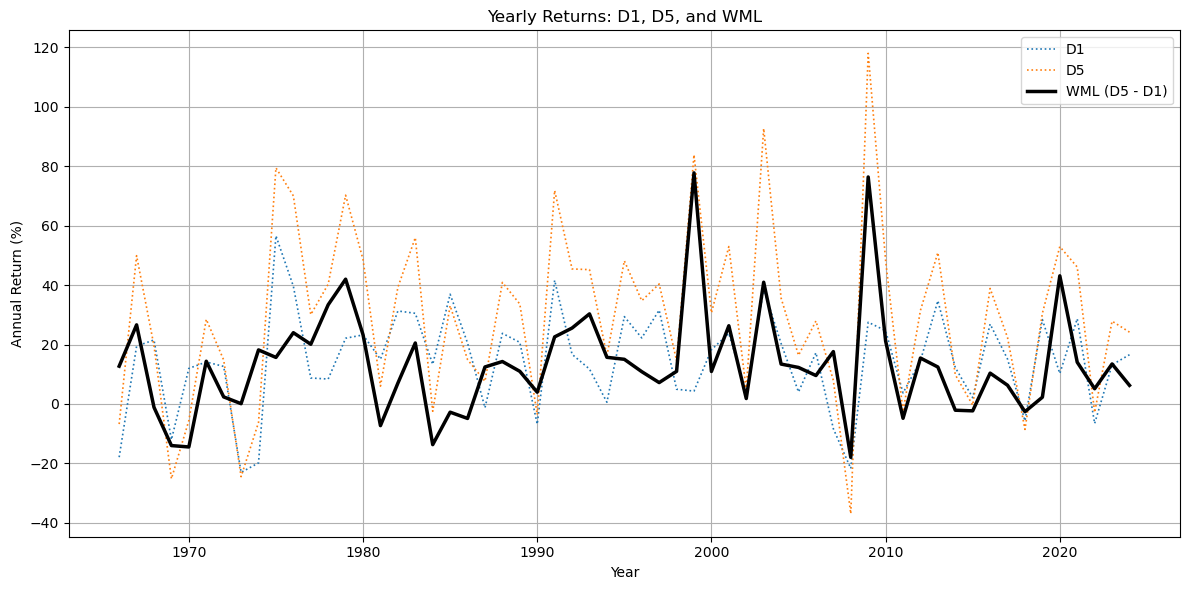

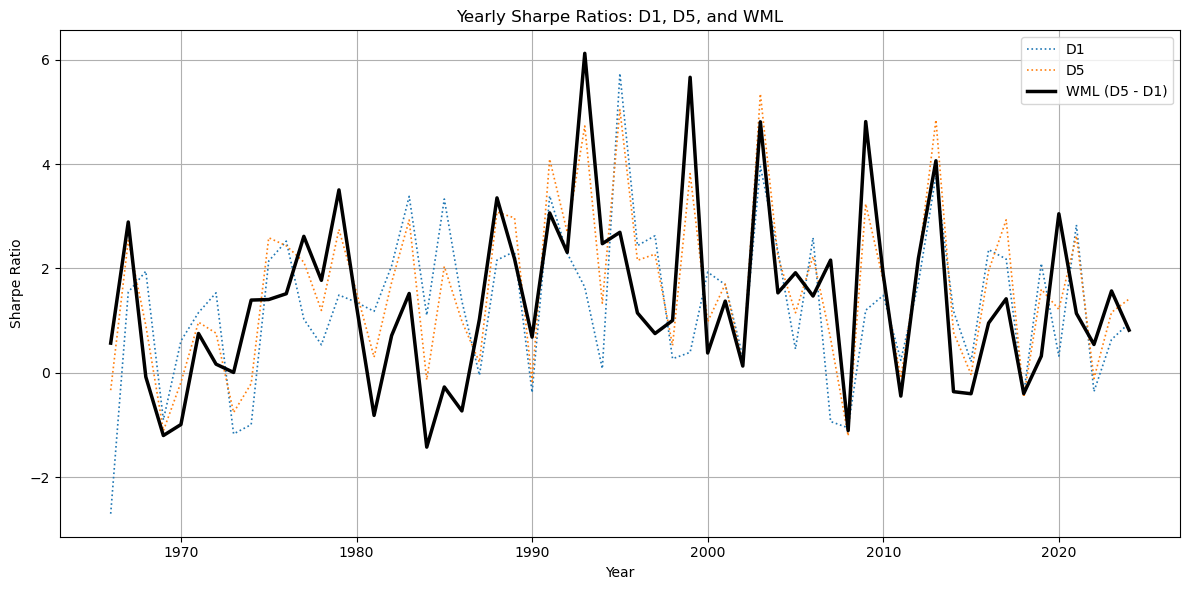

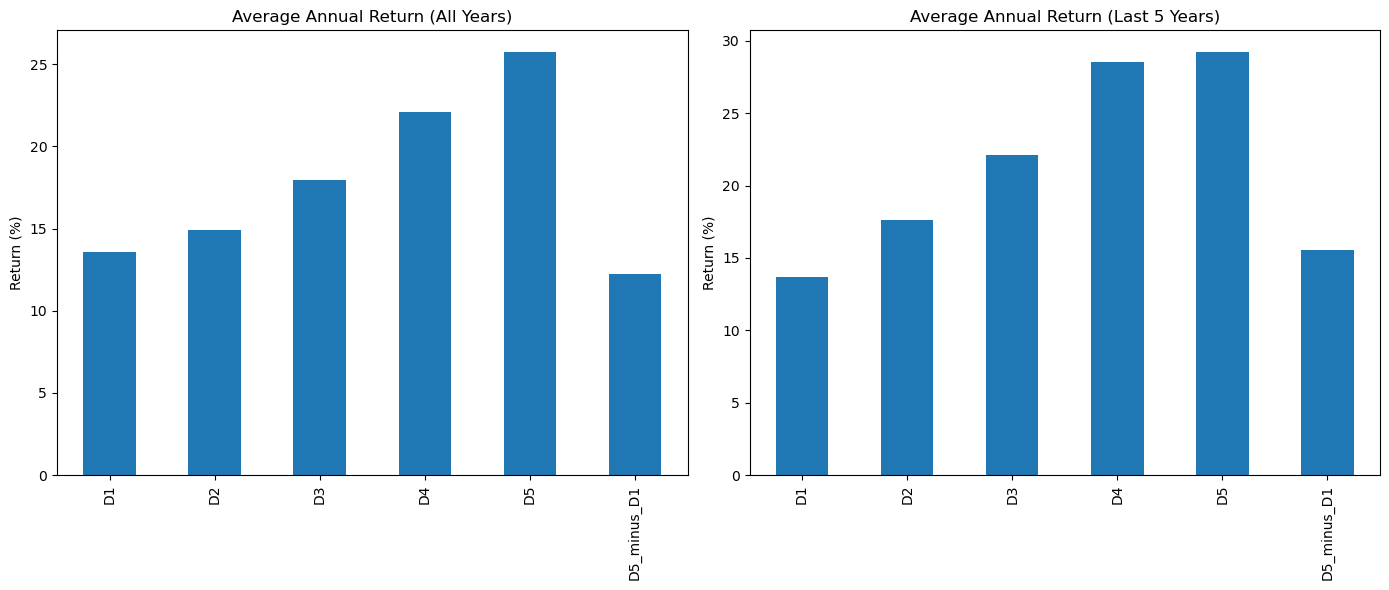

In [24]:
# ============================
# Step 8: Plot cumulative returns of WML Portfolio
# ============================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew, kurtosis

# Assume port_returns is already loaded and has a datetime index
# and columns like D1, D2, ..., D5, D5_minus_D1

# Convert index to datetime if not already
port_returns.index = pd.to_datetime(port_returns.index)

# Calculate yearly returns and Sharpe ratios
yearly_stats = []
for year, df in port_returns.groupby(port_returns.index.year):
    stats = {}
    for col in df.columns:
        ret = df[col].dropna()
        ann_return = (1 + ret).prod() - 1
        ann_vol = ret.std() * np.sqrt(12)
        sharpe = ann_return / ann_vol if ann_vol != 0 else np.nan
        stats[col] = {
            'AnnualReturn': ann_return * 100,
            'Sharpe': sharpe
        }
    stats_df = pd.DataFrame(stats).T
    stats_df['Year'] = year
    yearly_stats.append(stats_df)

# Combine all year-wise stats
yearly_stats_df = pd.concat(yearly_stats).reset_index().rename(columns={'index': 'Portfolio'})

# Portfolios to plot
selected_portfolios = ['D1', 'D5', 'D5_minus_D1']

plt.figure(figsize=(12, 6))
for portfolio in selected_portfolios:
    subset = yearly_stats_df[yearly_stats_df['Portfolio'] == portfolio]
    if portfolio == 'D5_minus_D1':
        plt.plot(subset['Year'], subset['AnnualReturn'], label='WML (D5 - D1)',
                 linewidth=2.5, linestyle='-', color='black')
    else:
        plt.plot(subset['Year'], subset['AnnualReturn'], label=portfolio,
                 linestyle=':', linewidth=1.2, alpha=1)
plt.title("Yearly Returns: D1, D5, and WML")
plt.xlabel("Year")
plt.ylabel("Annual Return (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Sharpe ratios
plt.figure(figsize=(12, 6))
for portfolio in selected_portfolios:
    subset = yearly_stats_df[yearly_stats_df['Portfolio'] == portfolio]
    if portfolio == 'D5_minus_D1':
        plt.plot(subset['Year'], subset['Sharpe'], label='WML (D5 - D1)',
                 linewidth=2.5, linestyle='-', color='black')
    else:
        plt.plot(subset['Year'], subset['Sharpe'], label=portfolio,
                 linestyle=':', linewidth=1.2, alpha=1)
plt.title("Yearly Sharpe Ratios: D1, D5, and WML")
plt.xlabel("Year")
plt.ylabel("Sharpe Ratio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Bar chart for all years and last 5 years
all_years_mean = port_returns.mean() * 12 * 100
last5_cutoff = port_returns.index.max() - pd.DateOffset(years=5)
last5_mean = port_returns[port_returns.index >= last5_cutoff].mean() * 12 * 100

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
all_years_mean.dropna().plot(kind='bar', ax=axs[0], title="Average Annual Return (All Years)")
axs[0].set_ylabel("Return (%)")
last5_mean.dropna().plot(kind='bar', ax=axs[1], title="Average Annual Return (Last 5 Years)")
axs[1].set_ylabel("Return (%)")
plt.tight_layout()
plt.show()

In [25]:
# ============================
# Step 9: FF Regression Tests across all years 
# ============================
import pandas as pd
import statsmodels.api as sm

def run_factor_regressions(port_returns, ff_data):
    factor_cols = ['Mkt-RF', 'SMB', 'HML']
    regression_results_capm = []
    regression_results_ff3 = []

    for q in port_returns.columns:
        Rp = port_returns[q].dropna()
        aligned_ff = ff_data.reindex(Rp.index)
        Rf = aligned_ff['RF']
        excess_ret = Rp - Rf
        X = aligned_ff[factor_cols]

        # Drop rows with any NaNs
        combined_df = pd.concat([excess_ret, X], axis=1).dropna()
        excess_ret = combined_df.iloc[:, 0]
        X_clean = combined_df[factor_cols]

        # CAPM regression
        X_capm = sm.add_constant(X_clean[['Mkt-RF']])
        capm_model = sm.OLS(excess_ret, X_capm).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
        regression_results_capm.append({
            'Portfolio': q,
            'alpha(ann %)': capm_model.params['const'] * 1200,
            't(alpha)': capm_model.tvalues['const'],
            'p(alpha)': capm_model.pvalues['const'],
            'beta_Mkt': capm_model.params['Mkt-RF'],
            't(beta_Mkt)': capm_model.tvalues['Mkt-RF'],
            'p(beta_Mkt)': capm_model.pvalues['Mkt-RF'],
            'R2_adj': capm_model.rsquared_adj * 100
        })

        # FF3 regression
        X_ff3 = sm.add_constant(X_clean)
        ff3_model = sm.OLS(excess_ret, X_ff3).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
        p = ff3_model.params
        t = ff3_model.tvalues
        pv = ff3_model.pvalues
        regression_results_ff3.append({
            'Portfolio': q,
            'alpha(ann %)': p['const'] * 1200,
            't(alpha)': t['const'],
            'p(alpha)': pv['const'],
            'beta_Mkt': p['Mkt-RF'],
            't(beta_Mkt)': t['Mkt-RF'],
            'p(beta_Mkt)': pv['Mkt-RF'],
            'beta_SMB': p['SMB'],
            't(beta_SMB)': t['SMB'],
            'p(beta_SMB)': pv['SMB'],
            'beta_HML': p['HML'],
            't(beta_HML)': t['HML'],
            'p(beta_HML)': pv['HML'],
            'R2_adj': ff3_model.rsquared_adj * 100
        })

    capm_df = pd.DataFrame(regression_results_capm).set_index('Portfolio')
    ff3_df = pd.DataFrame(regression_results_ff3).set_index('Portfolio')

    return capm_df, ff3_df


In [26]:
capm_df, ff3_df = run_factor_regressions(port_returns, ff_data)

In [27]:
capm_df.round(2)

,alpha(ann %),t(alpha),p(alpha),beta_Mkt,t(beta_Mkt),p(beta_Mkt),R2_adj
Portfolio,,,,,,,
D1,3.53,2.80,0.01,0.84,28.02,0.0,80.53
D2,3.42,2.66,0.01,1.00,32.47,0.0,85.27
D3,5.80,4.00,0.00,1.11,35.40,0.0,83.44
D4,9.43,5.55,0.00,1.20,35.62,0.0,80.69
D5,13.03,6.03,0.00,1.29,28.88,0.0,75.87
D5_minus_D1,5.01,2.61,0.01,0.46,11.79,0.0,32.81


In [28]:
ff3_df.round(2)

,alpha(ann %),t(alpha),p(alpha),beta_Mkt,t(beta_Mkt),p(beta_Mkt),beta_SMB,t(beta_SMB),p(beta_SMB),beta_HML,t(beta_HML),p(beta_HML),R2_adj
Portfolio,,,,,,,,,,,,,
D1,1.80,2.03,0.04,0.83,38.36,0.0,0.29,7.00,0.0,0.38,9.64,0.00,90.36
D2,1.95,2.30,0.02,0.95,48.28,0.0,0.43,9.64,0.0,0.30,7.44,0.00,94.34
D3,4.46,4.84,0.00,1.02,64.39,0.0,0.59,16.95,0.0,0.25,7.88,0.00,94.71
D4,8.22,7.46,0.00,1.07,55.77,0.0,0.73,19.24,0.0,0.20,8.46,0.00,94.11
D5,11.35,9.07,0.00,1.14,45.45,0.0,0.90,17.00,0.0,0.30,7.23,0.00,92.76
D5_minus_D1,5.06,3.33,0.00,0.32,9.50,0.0,0.61,12.78,0.0,-0.09,-1.40,0.16,60.34


In [29]:
# ============================
# Step 10: FF Regression Tests across recent 5 years 
# ============================
from pandas.tseries.offsets import DateOffset

# Step 1: Filter port_returns and ff_data to the last 5 years
cutoff_date = port_returns.index.max() - DateOffset(years=5)
port_returns_5y = port_returns[port_returns.index >= cutoff_date]
ff_data_5y = ff_data[ff_data.index >= cutoff_date]

# Step 2: Run regressions on this filtered data
capm_df_5y, ff3_df_5y = run_factor_regressions(port_returns_5y, ff_data_5y)

In [30]:
capm_df_5y.round(2)

,alpha(ann %),t(alpha),p(alpha),beta_Mkt,t(beta_Mkt),p(beta_Mkt),R2_adj
Portfolio,,,,,,,
D1,-5.95,-0.92,0.36,0.99,11.20,0.0,78.24
D2,-3.08,-0.56,0.57,1.14,13.50,0.0,85.53
D3,-1.01,-0.20,0.84,1.23,15.10,0.0,86.80
D4,4.06,0.84,0.40,1.30,16.21,0.0,87.75
D5,7.06,1.09,0.27,1.37,12.41,0.0,83.63
D5_minus_D1,10.63,2.44,0.01,0.38,6.64,0.0,42.58


In [31]:
ff3_df_5y.round(2)

,alpha(ann %),t(alpha),p(alpha),beta_Mkt,t(beta_Mkt),p(beta_Mkt),beta_SMB,t(beta_SMB),p(beta_SMB),beta_HML,t(beta_HML),p(beta_HML),R2_adj
Portfolio,,,,,,,,,,,,,
D1,1.09,0.63,0.53,0.82,22.12,0.0,0.62,7.73,0.00,0.40,8.70,0.00,96.35
D2,3.42,2.10,0.04,0.98,29.47,0.0,0.64,9.33,0.00,0.31,8.58,0.00,97.42
D3,5.68,4.78,0.00,1.05,35.13,0.0,0.81,19.42,0.00,0.19,8.47,0.00,97.96
D4,10.36,4.63,0.00,1.13,29.66,0.0,0.75,9.55,0.00,0.19,4.89,0.00,96.55
D5,14.97,3.98,0.00,1.16,28.20,0.0,0.80,7.57,0.00,0.36,6.60,0.00,95.41
D5_minus_D1,11.55,2.43,0.01,0.35,4.99,0.0,0.19,1.19,0.23,-0.04,-0.45,0.65,42.97


In [32]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [33]:
# ============================
# Step 11: Size vs Dispersion Quintile Analysis
# ============================
# Calculate market cap (if not already)
crsp_linked['market_cap'] = crsp_linked['PRC'].abs() * crsp_linked['SHROUT'] / 1000

# Remove missing or zero market caps
filtered = crsp_linked[crsp_linked['market_cap'] > 0].copy()

# Compute quantile breakpoints
quantiles = filtered['market_cap'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1.0]).values
labels = ['Q1 (Smallest)', 'Q2', 'Q3', 'Q4', 'Q5 (Largest)']

# Bin into size quantiles
filtered['size_bin'] = pd.cut(filtered['market_cap'], bins=quantiles, labels=labels, include_lowest=True)

# Summary of dispersion by size bin
summary = filtered.groupby('size_bin')['dispersion'].describe()
summary

,count,mean,std,min,25%,50%,75%,max
size_bin,,,,,,,,
Q1 (Smallest),375812.0,5.876830,235.007587,0.000585,0.294877,0.612945,1.613727,38700.718389
Q2,375806.0,3.887383,152.487961,0.011415,0.236628,0.487522,1.285044,40549.493615
Q3,375809.0,5.260507,368.882978,0.013609,0.229603,0.459880,1.212518,77253.245861
Q4,375809.0,3.104585,187.682778,0.011364,0.220749,0.427120,1.120336,77253.245861
Q5 (Largest),375809.0,2.480984,132.285248,0.011184,0.216234,0.384657,0.826734,28451.879076


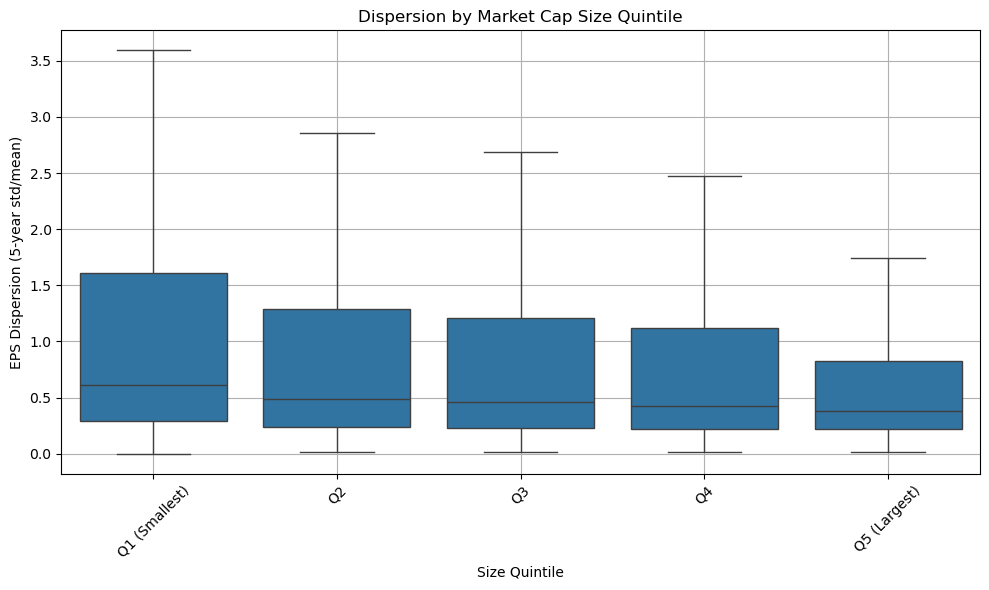

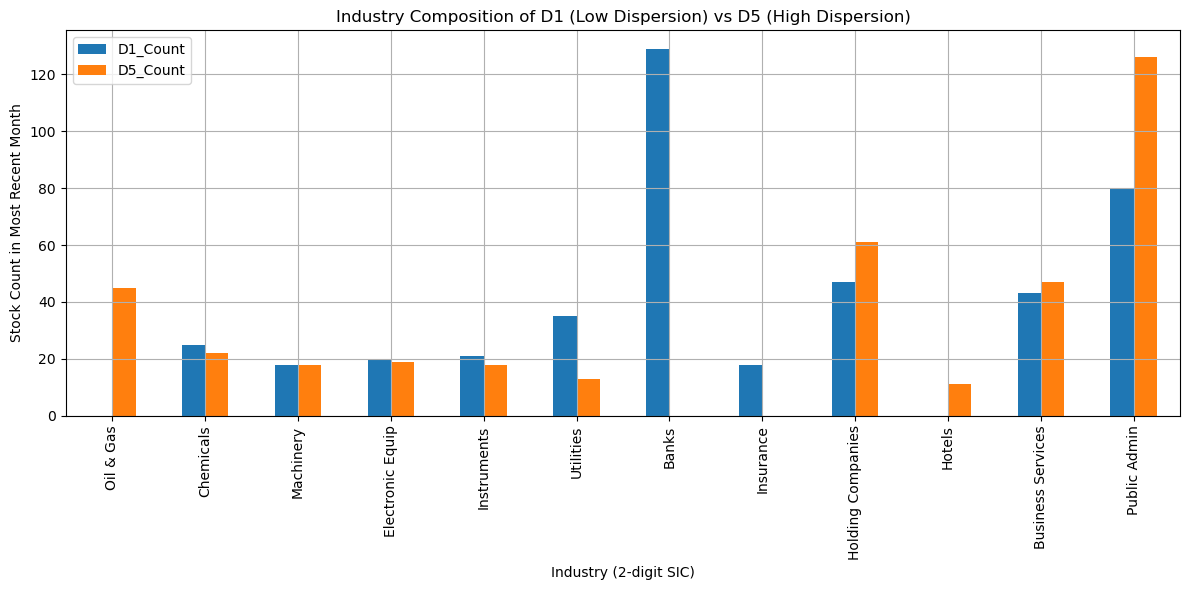

,Industry,D1_Count,D5_Count,Net_Long_Tilt
11,Public Admin,80.0,126.0,46.0
0,Oil & Gas,0.0,45.0,45.0
8,Holding Companies,47.0,61.0,14.0
9,Hotels,0.0,11.0,11.0
10,Business Services,43.0,47.0,4.0
2,Machinery,18.0,18.0,0.0
3,Electronic Equip,20.0,19.0,-1.0
1,Chemicals,25.0,22.0,-3.0
4,Instruments,21.0,18.0,-3.0
7,Insurance,18.0,0.0,-18.0


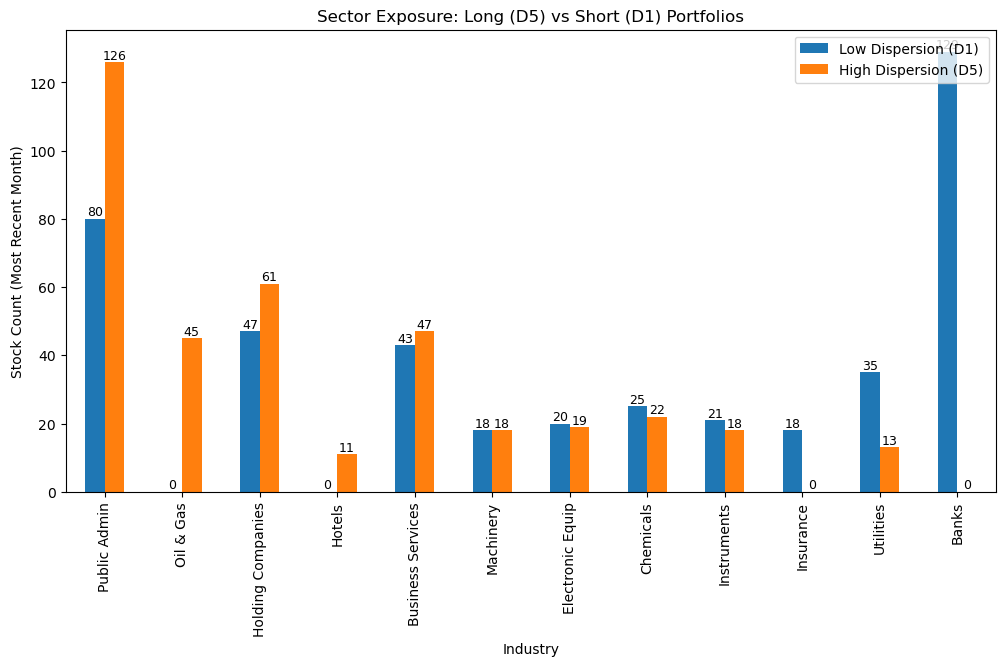

In [43]:
# ============================
# Step 12: Size & Industry vs Dispersion Plots
# ============================
import seaborn as sns

# Assume `crsp_linked_dispersion` is the DataFrame with dispersion and size_bin info
# Create boxplot for dispersion by size_bin
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered, x='size_bin', y='dispersion', showfliers=False)
plt.title('Dispersion by Market Cap Size Quintile')
plt.ylabel('EPS Dispersion (5-year std/mean)')
plt.xlabel('Size Quintile')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Create summary stats by industry (2-digit SIC codes)
crsp_linked['sic2'] = crsp_linked['SICCD'].astype(str).str[:2]

# === Filter for most recent month ===
latest_date = crsp_linked['date'].max()
latest_data = crsp_linked[crsp_linked['date'] == latest_date]

# === Get top 10 most frequent industries in D1 and D5 ===
d1_top = latest_data[latest_data['quintile'] == 1]['sic2'].value_counts().head(10)
d5_top = latest_data[latest_data['quintile'] == 5]['sic2'].value_counts().head(10)

# === Convert to DataFrames for plotting ===
d1_df = d1_top.reset_index()
d1_df.columns = ['Industry', 'D1_Count']
d5_df = d5_top.reset_index()
d5_df.columns = ['Industry', 'D5_Count']
industry_compare = pd.merge(d1_df, d5_df, on='Industry', how='outer').fillna(0)

sic2_map = {
    "60": "Banks",
    "63": "Insurance",
    "67": "Holding Companies",
    "70": "Hotels",
    "73": "Business Services",
    "28": "Chemicals",
    "36": "Electronic Equip",
    "35": "Machinery",
    "38": "Instruments",
    "99": "Public Admin",
    "13": "Oil & Gas",
    "49": "Utilities"
}
industry_compare['Industry'] = industry_compare['Industry'].map(sic2_map).fillna(industry_compare['Industry'])



# === Plot side-by-side barplot of D1 vs D5 industry counts ===
industry_compare.set_index('Industry')[['D1_Count', 'D5_Count']].plot(kind='bar', figsize=(12, 6))
plt.title('Industry Composition of D1 (Low Dispersion) vs D5 (High Dispersion)')
plt.ylabel('Stock Count in Most Recent Month')
plt.xlabel('Industry (2-digit SIC)')
plt.grid(True)
plt.tight_layout()
plt.show()


industry_compare['Net_Long_Tilt'] = industry_compare['D5_Count'] - industry_compare['D1_Count']
industry_compare = industry_compare.sort_values(by='Net_Long_Tilt', ascending=False)
ax = industry_compare.set_index('Industry')[['D1_Count', 'D5_Count']].plot(kind='bar', figsize=(12, 6))
for c in ax.containers:
    ax.bar_label(c, label_type='edge', fontsize=9)

plt.title('Sector Exposure: Long (D5) vs Short (D1) Portfolios')
plt.ylabel('Stock Count (Most Recent Month)')
plt.xlabel('Industry')
plt.legend(['Low Dispersion (D1)', 'High Dispersion (D5)'], loc='upper right')

industry_compare

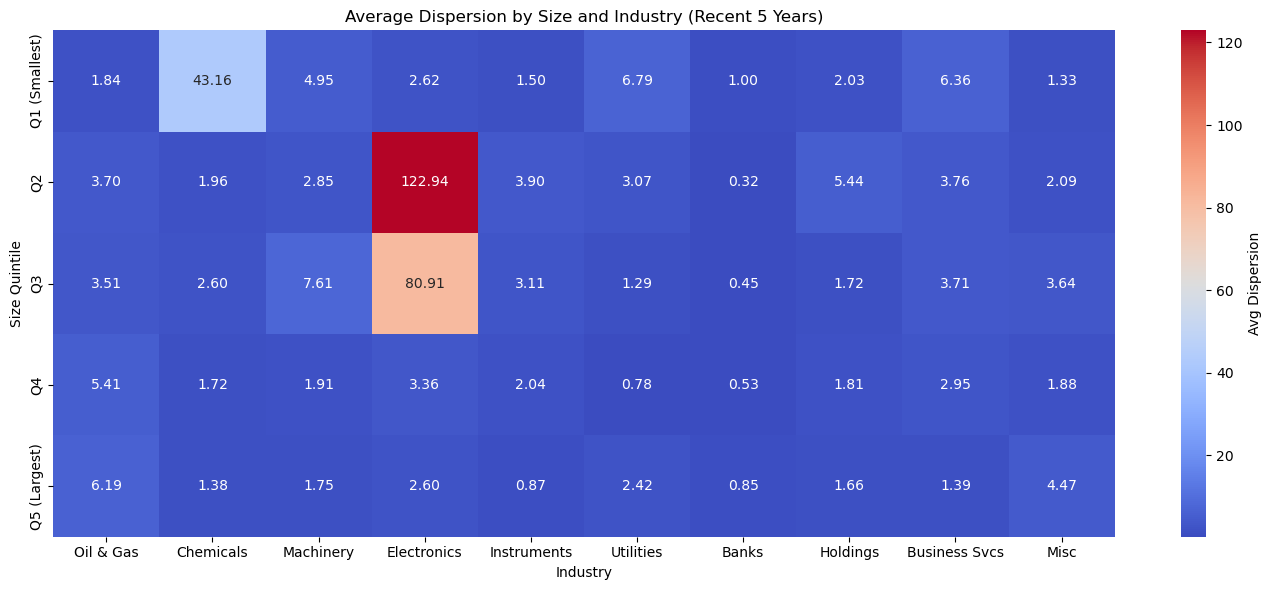

In [35]:
# ============================
# Step 13: Industry & Size Dispersion Matrix Plot 
# ============================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Data Preparation ---
disp_df = crsp_linked[['date', 'dispersion', 'market_cap', 'SICCD']].copy()
disp_df = disp_df.dropna(subset=['dispersion', 'market_cap'])
disp_df['year'] = disp_df['date'].dt.year

# Size Binning
quantiles = disp_df['market_cap'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1.0]).values
labels = ['Q1 (Smallest)', 'Q2', 'Q3', 'Q4', 'Q5 (Largest)']
disp_df['size_bin'] = pd.cut(disp_df['market_cap'], bins=quantiles, labels=labels, include_lowest=True)

# Industry Tag
disp_df['sic2'] = disp_df['SICCD'].astype(str).str[:2]

# Focus on Recent 5 Years
cutoff_year = disp_df['year'].max() - 5
recent_df = disp_df[disp_df['year'] >= cutoff_year].copy()

# Optional: Log transform to control for extreme skew
# recent_df['dispersion'] = np.log1p(recent_df['dispersion'])

# --- SIC Code Mapping ---
sic2_map = {
    "13": "Oil & Gas", "28": "Chemicals", "35": "Machinery",
    "36": "Electronics", "38": "Instruments", "49": "Utilities",
    "60": "Banks", "67": "Holdings", "73": "Business Svcs",
    "99": "Misc"
}

# Compute mean dispersion
avg_disp = (
    recent_df.groupby(['size_bin', 'sic2'])['dispersion']
    .mean()
    .reset_index()
    .pivot(index='size_bin', columns='sic2', values='dispersion')
)

# Keep only mapped industries
top_industries = list(sic2_map.keys())
avg_disp = avg_disp[top_industries]
avg_disp.columns = [sic2_map.get(col, col) for col in avg_disp.columns]

# Compute counts for annotation
count_matrix = (
    recent_df.groupby(['size_bin', 'sic2'])['dispersion']
    .count()
    .reindex_like(avg_disp)
)

# --- Plot ---
plt.figure(figsize=(14, 6))
sns.heatmap(avg_disp, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Avg Dispersion'})
plt.title("Average Dispersion by Size and Industry (Recent 5 Years)")
plt.ylabel("Size Quintile")
plt.xlabel("Industry")
plt.tight_layout()
plt.show()

                 Annualized Alpha (%)  Volatility (%)  Sharpe Ratio  Skewness  \
VolTargeted WML             23.164727       18.420668       1.25754  0.718497   

                 Kurtosis  
VolTargeted WML   0.25547  
              Annualized Alpha (%)  Volatility (%)  Sharpe Ratio  Skewness  \
Net of Costs             20.764727       18.420668      1.127252  0.718497   

              Kurtosis  
Net of Costs   0.25547  
FF3 Gross Alpha: 16.17%, t-stat: 1.99
FF3 Net Alpha: 13.77%, t-stat: 1.69
CAGR (Strategy - Gross): 26.76%
CAGR (Strategy - Net of Costs): 23.80%
CAGR (Market): 19.29%


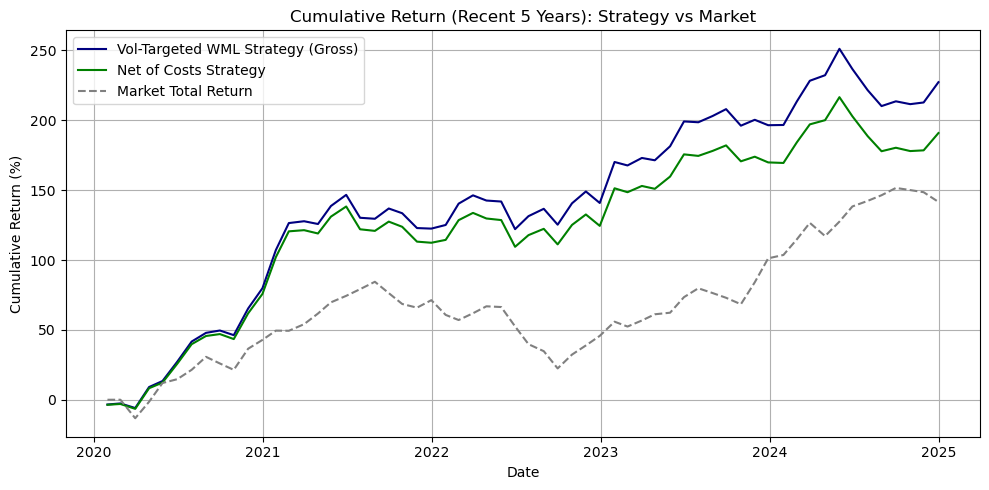

In [36]:
# ============================
# Step 14: 5-year Trading Strategy Implementation
# ============================
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from scipy.stats import skew, kurtosis

# === Raw WML returns (less aggressive winsorization) ===
wml_ret = port_returns['D5_minus_D1']
wml_ret = pd.Series(winsorize(wml_ret, limits=[0.005, 0.005]), index=wml_ret.index)
wml_ret.name = 'Raw_WML'

# === Volatility Targeting ===
def volatility_target(returns, target_vol=0.20):
    realized_vol = returns.std() * np.sqrt(12)
    scaling_factor = target_vol / realized_vol if realized_vol != 0 else 1.0
    return returns * scaling_factor

wml_vol = volatility_target(wml_ret)
wml_vol.name = 'VolTargeted_WML'

# === Load Fama-French 3-Factor Data ===
ff = web.DataReader("F-F_Research_Data_Factors", "famafrench", start="1990")[0] / 100
ff.index = ff.index.to_timestamp('M')

# === Align Dates Using merge_asof ===
returns_df = wml_vol.to_frame().sort_index()
ff = ff.sort_index()
merged = pd.merge_asof(returns_df, ff, left_index=True, right_index=True, direction='backward')
merged['ExcessRet'] = merged['VolTargeted_WML'] - merged['RF']

# === Restrict to Recent 5 Years ===
recent_window = 5 * 12
merged_recent = merged.iloc[-recent_window:].copy()

# === Simulate Transaction Costs ===
transaction_cost = 0.002  # 20 bps
merged_recent['NetReturn'] = merged_recent['VolTargeted_WML'] - transaction_cost
merged_recent['NetExcessRet'] = merged_recent['NetReturn'] - merged_recent['RF']

# === Performance Metrics ===
def analyze_returns(excess_ret, name='Strategy'):
    excess_ret = excess_ret.dropna()
    ann_ret = excess_ret.mean() * 12
    ann_vol = excess_ret.std() * np.sqrt(12)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    return pd.DataFrame({
        'Annualized Alpha (%)': [ann_ret * 100],
        'Volatility (%)': [ann_vol * 100],
        'Sharpe Ratio': [sharpe],
        'Skewness': [skew(excess_ret)],
        'Kurtosis': [kurtosis(excess_ret, fisher=True)]
    }, index=[name])

strategy_stats = analyze_returns(merged_recent['ExcessRet'], name='VolTargeted WML')
net_stats = analyze_returns(merged_recent['NetExcessRet'], name='Net of Costs')
print(strategy_stats)
print(net_stats)

# === FF3 Regressions (Gross and Net) ===
X_ff3 = sm.add_constant(merged_recent[['Mkt-RF', 'SMB', 'HML']])
ff3_model = sm.OLS(merged_recent['ExcessRet'], X_ff3).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
ff3_model_net = sm.OLS(merged_recent['NetExcessRet'], X_ff3).fit(cov_type='HAC', cov_kwds={'maxlags': 6})

alpha_annual = ff3_model.params['const'] * 12
t_alpha = ff3_model.tvalues['const']

alpha_annual_net = ff3_model_net.params['const'] * 12
t_alpha_net = ff3_model_net.tvalues['const']

print(f"FF3 Gross Alpha: {alpha_annual:.2%}, t-stat: {t_alpha:.2f}")
print(f"FF3 Net Alpha: {alpha_annual_net:.2%}, t-stat: {t_alpha_net:.2f}")

# === CAGR Calculation (Gross and Net) ===
n_months = len(merged_recent)
n_years = n_months / 12

cumulative_gross = (1 + merged_recent['VolTargeted_WML']).prod()
cumulative_net = (1 + merged_recent['NetReturn']).prod()
cumulative_market = (1 + merged_recent['Mkt-RF'] + merged_recent['RF']).prod()

cagr_gross = cumulative_gross ** (1 / n_years) - 1
cagr_net = cumulative_net ** (1 / n_years) - 1
cagr_market = cumulative_market ** (1 / n_years) - 1

print(f"CAGR (Strategy - Gross): {cagr_gross*100:.2f}%")
print(f"CAGR (Strategy - Net of Costs): {cagr_net*100:.2f}%")
print(f"CAGR (Market): {cagr_market*100:.2f}%")

# === Plot Cumulative Returns ===
cum_wml = (1 + merged_recent['VolTargeted_WML']).cumprod() - 1
cum_net = (1 + merged_recent['NetReturn']).cumprod() - 1
cum_mkt = (1 + merged_recent['Mkt-RF'] + merged_recent['RF']).cumprod() - 1

plt.figure(figsize=(10, 5))
plt.plot(cum_wml * 100, label='Vol-Targeted WML Strategy (Gross)', color='navy')
plt.plot(cum_net * 100, label='Net of Costs Strategy', color='green')
plt.plot(cum_mkt * 100, label='Market Total Return', color='gray', linestyle='--')
plt.title('Cumulative Return (Recent 5 Years): Strategy vs Market')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [37]:
strategy_stats.round(2)

,Annualized Alpha (%),Volatility (%),Sharpe Ratio,Skewness,Kurtosis
VolTargeted WML,23.16,18.42,1.26,0.72,0.26


In [38]:
net_stats.round(2)

,Annualized Alpha (%),Volatility (%),Sharpe Ratio,Skewness,Kurtosis
Net of Costs,20.76,18.42,1.13,0.72,0.26


In [39]:
print(ff3_model.summary())

                            OLS Regression Results                            
Dep. Variable:              ExcessRet   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     9.895
Date:                Sun, 29 Jun 2025   Prob (F-statistic):           2.47e-05
Time:                        16:21:55   Log-Likelihood:                 102.08
No. Observations:                  60   AIC:                            -196.2
Df Residuals:                      56   BIC:                            -187.8
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0135      0.007      1.990      0.0

In [40]:
print(ff3_model_net.summary())

                            OLS Regression Results                            
Dep. Variable:           NetExcessRet   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     9.895
Date:                Sun, 29 Jun 2025   Prob (F-statistic):           2.47e-05
Time:                        16:21:55   Log-Likelihood:                 102.08
No. Observations:                  60   AIC:                            -196.2
Df Residuals:                      56   BIC:                            -187.8
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0115      0.007      1.694      0.0

In [41]:
def calculate_max_drawdown(cumulative_returns):
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_dd = drawdown.min()
    return max_dd

In [42]:
# Compute cumulative return series from Net returns
cum_returns_net = (1 + merged_recent['NetReturn']).cumprod()

# Max Drawdown (Net)
max_dd_net = calculate_max_drawdown(cum_returns_net)

# Calmar Ratio
calmar_net = cagr_net / abs(max_dd_net) if max_dd_net != 0 else np.nan

print(f"Max Drawdown (Net): {max_dd_net:.2%}")
print(f"Calmar Ratio (Net): {calmar_net:.2f}")


Max Drawdown (Net): -12.22%
Calmar Ratio (Net): 1.95
